In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

import tqdm

# Load data

In [2]:
test_byrd_grid = pd.read_csv("data/test_byrd_grid_xyvxvys.csv", index_col = 0)
train_byrd_points = pd.read_csv("data/training_byrd_points_txyvxvys.csv", index_col = 0)

# Subset

In [3]:
# Narrow stream
x_min = 420000 + 500
x_max = 445000

y_min = -900000 + 500
y_max = -875000

# Island (interesting)
# Somewhat sparse region
x_min = 420000 + 500
x_max = 445000

y_min = -850000 + 500
y_max = -825000

In [4]:
test_byrd_grid_island = test_byrd_grid[
    (test_byrd_grid.x >= x_min) & 
    (test_byrd_grid.x <= x_max) & 
    (test_byrd_grid.y >= y_min) & 
    (test_byrd_grid.y <= y_max)]

train_byrd_points_island = train_byrd_points[
    (train_byrd_points.x >= x_min) & 
    (train_byrd_points.x <= x_max) & 
    (train_byrd_points.y >= y_min) & 
    (train_byrd_points.y <= y_max)]

In [5]:
test_byrd_grid_island

,x,y,vx,vy,s
19741,420500.0,-825000.0,-29.679472,-43.734898,1612.973999
19742,421000.0,-825000.0,-30.359507,-42.564259,1614.990601
19743,421500.0,-825000.0,-31.090704,-40.435879,1618.321289
19744,422000.0,-825000.0,-31.598083,-40.088215,1621.547119
19745,422500.0,-825000.0,-31.903746,-39.905106,1624.033691
...,...,...,...,...,...
39386,443000.0,-849500.0,-68.255219,-79.983032,1443.015991
39387,443500.0,-849500.0,-69.089012,-81.987267,1440.385742
39388,444000.0,-849500.0,-70.647011,-83.127373,1438.338501
39389,444500.0,-849500.0,-71.925407,-84.682220,1436.975098


In [6]:
train_byrd_points_island

,t,x,y,vx,vy,s
6651,1627.820000,420500,-836000,-31.715158,-53.546165,1526.255249
6652,1647.787059,420500,-837000,-30.827446,-53.940029,1515.565552
6653,1543.818235,420500,-841000,-12.945273,-55.431419,1479.151733
6654,1509.241538,420500,-849500,10.087988,-59.968884,1388.470337
6722,1596.740000,421000,-837000,-31.306444,-52.968971,1527.552490
...,...,...,...,...,...,...
10373,1411.483889,445000,-836500,-43.615459,-50.295490,1517.367676
10374,1397.357500,445000,-837000,-44.262169,-51.031841,1512.411377
10375,1615.907222,445000,-842000,-55.960617,-54.254658,1485.495972
10376,1719.850000,445000,-846000,-63.310284,-66.906433,1460.750000


In [8]:
cvals  = [-2000, -1500, -1000, -500, -1,
           0, 
          1, 250, 500, 750, 1000]

colors = ["#001079", "#0023c1", "#006cef", "#47bdfc", "#bee6fa", 
          "#7eb3a1",
          "#2D6E2A", "#DFFBBC", "#AFAD48", "#7D5F18", "#481B02"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

bedmachine_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

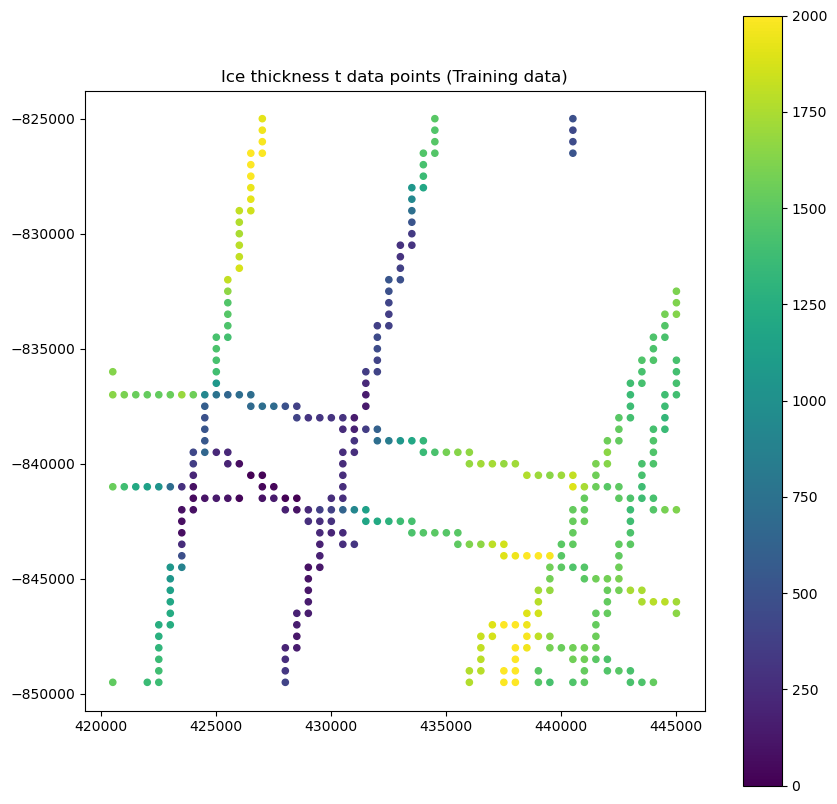

In [16]:
# XX, YY = np.meshgrid(test_byrd_grid_island.x, test_byrd_grid_island.y)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(train_byrd_points_island["x"], train_byrd_points_island["y"], 
           c = train_byrd_points_island["t"], 
           s = 20, 
           cmap = "viridis", vmin = 0, vmax = 2000)

ax.set_title("Ice thickness observations t (training data)")
fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

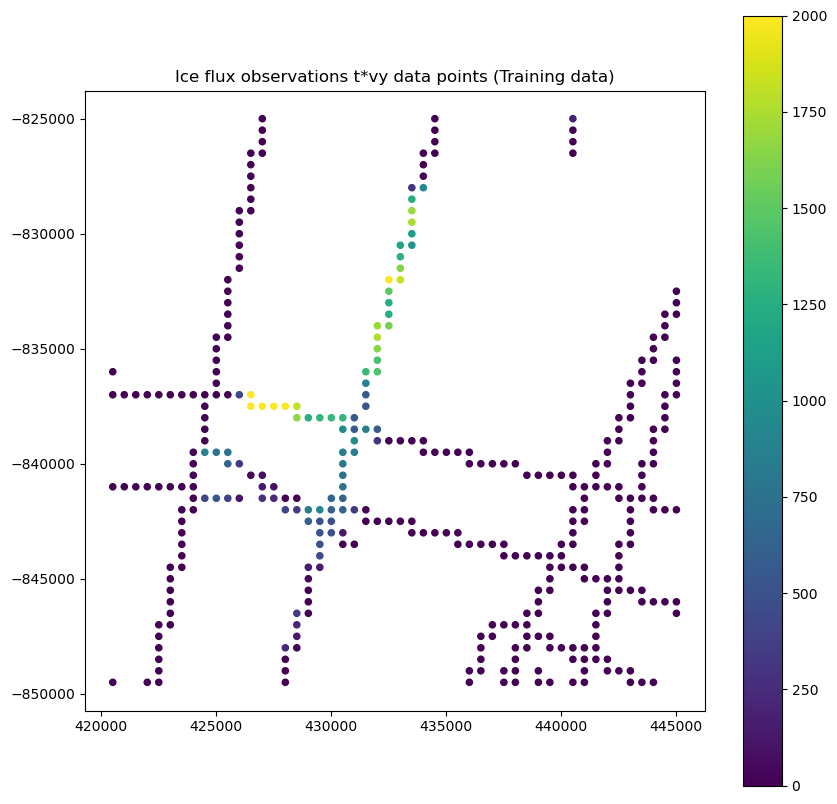

In [19]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(train_byrd_points_island["x"], train_byrd_points_island["y"], 
           c = train_byrd_points_island["t"] * train_byrd_points_island["vy"], 
           s = 20, 
           cmap = "viridis", vmin = 0, vmax = 2000)

ax.set_title("Ice flux observations t*vy (training data)")
fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

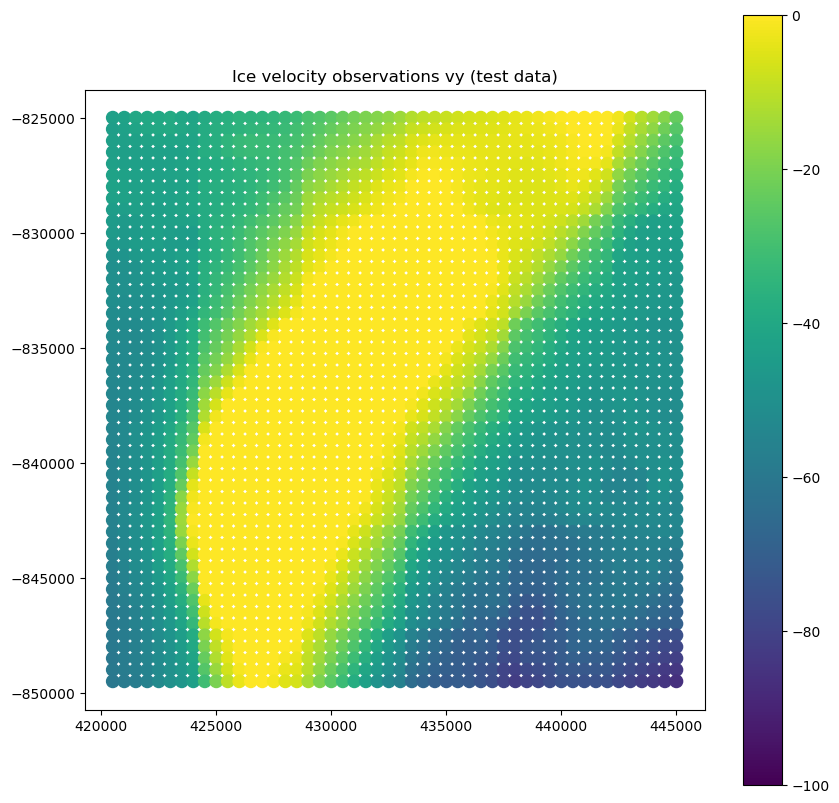

In [33]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(test_byrd_grid_island["x"], test_byrd_grid_island["y"], 
           c = test_byrd_grid_island["vy"], 
           s = 80, 
           cmap = "viridis", vmin = -100, vmax = 0)

ax.set_title("Ice velocity observations vy (test data)")
fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Shape of tensors should be 

- Inputs need to be normalised otherwise it can't learn.
- raw_lengthscale can be converted with lengthscale = torch.nn.functional.softplus(raw_lengthscale)
- with ard the printing is different


In [219]:
# train_y_unnorm = torch.tensor(train_byrd_points_island['t'].values).to(device)
# train_x_unnorm = torch.tensor(train_byrd_points_island[['x', 'y']].values).to(device)

train_y_unnorm = torch.tensor(train_byrd_points_island['t'].values).to(device)
train_x_unnorm = torch.tensor(train_byrd_points_island[['x', 'y', 'vx', 'vy', 's']].values).to(device)

# Leave y unnormalised because scalar takes care of this
train_y = train_y_unnorm

# normalise
min_vals, _ = torch.min(train_x_unnorm, dim = 0)
max_vals, _ = torch.max(train_x_unnorm, dim = 0)
range_vals = max_vals - min_vals

train_x = (train_x_unnorm - min_vals) / range_vals
train_x = train_x.float()

# Needs to be scalar
print(train_y.shape)
print(train_x.shape) # torch.Size([363, 2])
# print(train_x.dtype)

torch.Size([363])
torch.Size([363, 5])


## Normalise test with train min and range

In [221]:
test_x_unnorm = torch.tensor(test_byrd_grid_island[['x', 'y', 'vx', 'vy', 's']].values).to(device)
# use same range as training data
test_x = (test_x_unnorm - min_vals) / range_vals
test_x = test_x.float()
# print(test_x.dtype)

test_x

torch.float32


# Improvement over regular SE kernel

In [246]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = 2, active_dims = [0, 1])).double()
        # ard_num_dims = 2

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

# Change starting point
model.covar_module.base_kernel.lengthscale = 0.1

In [254]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f, %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # Without ard: model.covar_module.base_kernel.lengthscale.item(),
        model.covar_module.base_kernel.lengthscale.tolist()[0][0], model.covar_module.base_kernel.lengthscale.tolist()[0][1],
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/1000 - Loss: 2684.214   lengthscale: 0.169, 0.226   noise: 14.983
Iter 2/1000 - Loss: 2681.449   lengthscale: 0.154, 0.207   noise: 15.083
Iter 3/1000 - Loss: 2645.162   lengthscale: 0.165, 0.221   noise: 15.183
Iter 4/1000 - Loss: 2628.571   lengthscale: 0.176, 0.236   noise: 15.282
Iter 5/1000 - Loss: 2615.280   lengthscale: 0.180, 0.242   noise: 15.382
Iter 6/1000 - Loss: 2592.891   lengthscale: 0.178, 0.240   noise: 15.482
Iter 7/1000 - Loss: 2568.935   lengthscale: 0.172, 0.234   noise: 15.583
Iter 8/1000 - Loss: 2549.241   lengthscale: 0.166, 0.226   noise: 15.683
Iter 9/1000 - Loss: 2533.509   lengthscale: 0.162, 0.220   noise: 15.782
Iter 10/1000 - Loss: 2517.849   lengthscale: 0.160, 0.217   noise: 15.881
Iter 11/1000 - Loss: 2499.896   lengthscale: 0.160, 0.216   noise: 15.980
Iter 12/1000 - Loss: 2480.452   lengthscale: 0.163, 0.219   noise: 16.078
Iter 13/1000 - Loss: 2461.654   lengthscale: 0.167, 0.223   noise: 16.176
Iter 14/1000 - Loss: 2444.904   lengthscale: 0.

In [255]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

In [256]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(1000,))

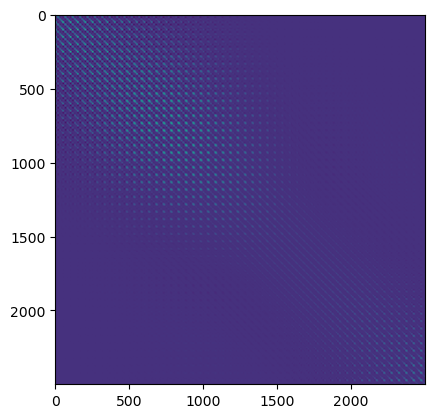

In [257]:
plt.imshow(f_covar.cpu().detach().numpy())

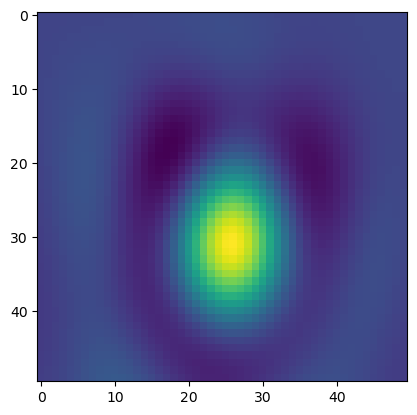

In [258]:
# covar between point and 2D field
# Posterior aka we seen data
plt.imshow(f_covar[:, 45*35].reshape(50, 50).cpu().detach().numpy())

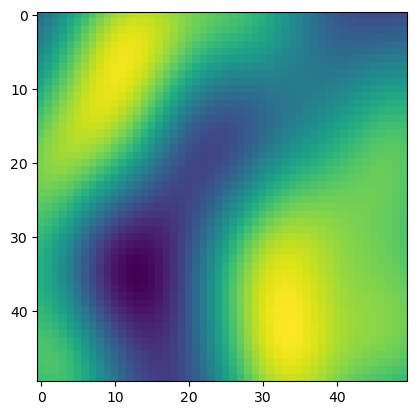

In [259]:
plt.imshow(f_mean.reshape(50, 50).cpu().detach().numpy())

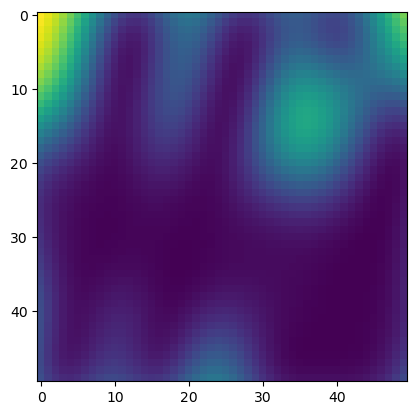

In [260]:
plt.imshow(f_var.reshape(50, 50).cpu().detach().numpy())

### Noise explosion

In [261]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")
    print(f"Requires gradient: {param.requires_grad}")
    print("-----------------------------")

Parameter name: likelihood.noise_covar.raw_noise
Parameter value: Parameter containing:
tensor([58.5183], device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor(109.0068, device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor(53.9706, device='cuda:0', dtype=torch.float64, requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[-1.7530, -1.4247]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Requires gradient: True
-----------------------------


- model.covar_module.raw_outputscale.item() and model.covar_module.outputscale.item() are the same.
- model.mean_module.constant.raw_item() and model.mean_module.constant.item() are the same.
- model.likelihood.noise_covar.raw_noise.item() and model.likelihood.noise_covar.noise.item() are the same.

In [245]:
model.covar_module.base_kernel.lengthscale.tolist()
# same as torch.nn.functional.softplus(model.covar_module.base_kernel.raw_lengthscale)

# Lengthscale in meters
print(model.covar_module.base_kernel.lengthscale * range_vals[:2])

tensor([[2450.0000, 2450.0000]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)


# Covariance transfer

In [298]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [4])).double()

        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [4])).double()

        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2).double() * gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2).double() * gpytorch.kernels.RBFKernel(active_dims = [4]).double())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

In [300]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale:    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # Without ard: model.covar_module.base_kernel.lengthscale.item(),
        #
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/1000 - Loss: 294.094   lengthscale:    noise: 5.277
Iter 2/1000 - Loss: 286.626   lengthscale:    noise: 5.377
Iter 3/1000 - Loss: 275.165   lengthscale:    noise: 5.474
Iter 4/1000 - Loss: 266.928   lengthscale:    noise: 5.573
Iter 5/1000 - Loss: 259.235   lengthscale:    noise: 5.672
Iter 6/1000 - Loss: 250.822   lengthscale:    noise: 5.771
Iter 7/1000 - Loss: 242.532   lengthscale:    noise: 5.870
Iter 8/1000 - Loss: 235.110   lengthscale:    noise: 5.968
Iter 9/1000 - Loss: 228.508   lengthscale:    noise: 6.065
Iter 10/1000 - Loss: 222.142   lengthscale:    noise: 6.160
Iter 11/1000 - Loss: 215.739   lengthscale:    noise: 6.253
Iter 12/1000 - Loss: 209.459   lengthscale:    noise: 6.344
Iter 13/1000 - Loss: 203.560   lengthscale:    noise: 6.434
Iter 14/1000 - Loss: 198.146   lengthscale:    noise: 6.523
Iter 15/1000 - Loss: 193.113   lengthscale:    noise: 6.610
Iter 16/1000 - Loss: 188.275   lengthscale:    noise: 6.697
Iter 17/1000 - Loss: 183.533   lengthscale:    no

In [301]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(1000,))

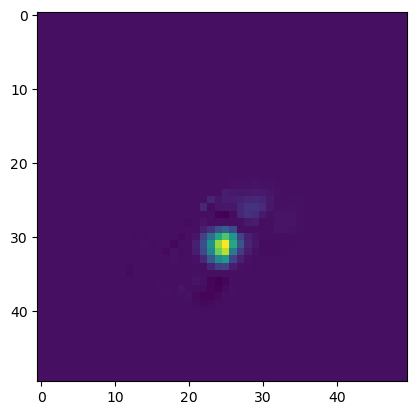

In [302]:
plt.imshow(f_covar[:, 45*35].reshape(50, 50).cpu().detach().numpy())

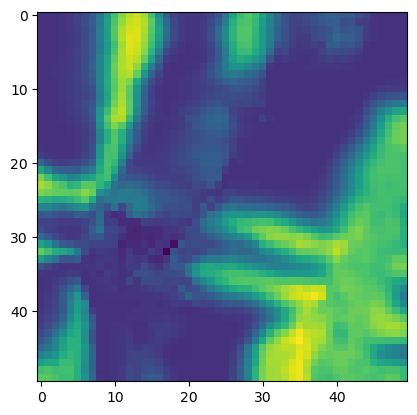

In [303]:
plt.imshow(f_mean.reshape(50, 50).cpu().detach().numpy())

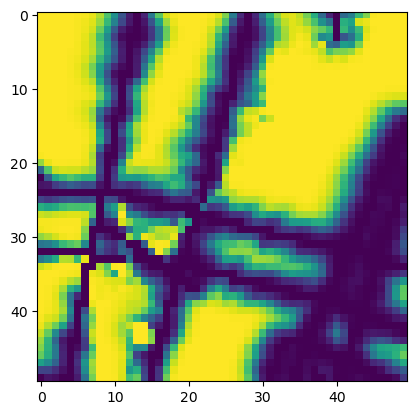

In [304]:
plt.imshow(f_var.reshape(50, 50).cpu().detach().numpy())

In [305]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")
    print(f"Requires gradient: {param.requires_grad}")
    print("-----------------------------")

Parameter name: likelihood.noise_covar.raw_noise
Parameter value: Parameter containing:
tensor([16.6907], device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor(62.6123, device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.kernels.0.raw_outputscale
Parameter value: Parameter containing:
tensor(28.1403, device='cuda:0', dtype=torch.float64, requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.kernels.0.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[-2.6204, -3.1777]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.kernels.1.raw_outputscale
Parameter value: Parameter containing:
tensor(28.1403, device='cuda:0', dtype=torch.f

In [278]:
# raw_outputscale not learned?

# Loss term

- Can we make this probabilistic?
- https://www.google.com/search?q=gpytorch+custom+loss+term&sca_esv=fb9ba6523a533ee8&rlz=1C5CHFA_enDE800DE803&sxsrf=ADLYWIK8eYmzeJo53EkN4DL55UB2UodT9A%3A1730856378181&ei=usUqZ6XfCtTw4-EPhPCwaA&ved=0ahUKEwilpNC8xsaJAxVU-DgGHQQ4DA0Q4dUDCA8&uact=5&oq=gpytorch+custom+loss+term&gs_lp=Egxnd3Mtd2l6LXNlcnAiGWdweXRvcmNoIGN1c3RvbSBsb3NzIHRlcm0yChAhGKABGMMEGApIrxtQ1g9Y4RlwAngBkAEAmAHbAaABmwmqAQUwLjUuMbgBA8gBAPgBAZgCBaAC3ATCAgoQABiwAxjWBBhHwgIIECEYoAEYwwSYAwCIBgGQBgiSBwUyLjIuMaAHmBU&sclient=gws-wiz-serp

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [4])).double()

        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2)).double() * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [4])).double()

        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims = [0, 1], ard_num_dims = 2).double() * gpytorch.kernels.RBFKernel(active_dims = [2, 3], ard_num_dims = 2).double() * gpytorch.kernels.RBFKernel(active_dims = [4]).double())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000

# weight for divergence free
w_divergence_free = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) + w_divergence_free 

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale:    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # Without ard: model.covar_module.base_kernel.lengthscale.item(),
        #
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [310]:
# Multivariate normal
likelihood(model(test_x))
# normal dist around velocity



MultivariateNormal(loc: torch.Size([2500]))

In [345]:
std_v = 10

vx_dist = gpytorch.distributions.MultivariateNormal(torch.tensor(test_byrd_grid_island[['vx']].values).squeeze(), covariance_matrix = torch.eye(2500) * std_v)

vy_dist = gpytorch.distributions.MultivariateNormal(torch.tensor(test_byrd_grid_island[['vy']].values).squeeze(), covariance_matrix = torch.eye(2500) * std_v)

In [346]:
vy_dist

MultivariateNormal(loc: torch.Size([2500]), covariance_matrix: torch.Size([2500, 2500]))

# KL divergence between mass balance and 

In [344]:
likelihood(model(test_x)) * vx_dist

RuntimeError: Can only multiply by scalars

# Tasks

Tasks:
- compare kernels
- zero mean
- other mean
- https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_DistributionalKernel.html

Evaluation
- diagonal slice for 